In [5]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `c:\Users\henhen724\Desktop\LabNotebooks\DickeModel\analysis`


In [6]:
using QuantumOptics
using DiffEqNoiseProcess
using LaTeXStrings
using Random
using DelimitedFiles
using NPZ, Printf
using LinearAlgebra
using DifferentialEquations
using SpecialFunctions
using SparseArrays
using StatsBase
using Optim
using JLD2
using BenchmarkTools
using Polynomials
include("HenryLib.jl")

make_white_noise (generic function with 1 method)

In [6]:
function diag_dicke(λrel; Δc = 2π*20, ωz = 2π*0.01, fockmax = 4, Nspin=20, Nvecs=4)
    fb = FockBasis(fockmax)
    sb = SpinBasis(Nspin//2)
    bases = [sb, fb]
    a = mb(destroy(fb), bases, 2)
    Sx = mb(sigmax(sb), bases, 1)/2
    Sy = mb(sigmay(sb), bases, 1)/2
    Sz = mb(sigmaz(sb), bases, 1)/2

    # κ = 2π*0.15 # MHz
    # Δc = 2π*20 # MHz
    # ωz = 2π*0.01 # MHz
    λc = 1/2*sqrt(Δc * ωz) 
    λ = λrel*λc

    H = Δc*dagger(a)*a + ωz*Sz + 2*λ*(dagger(a) + a)*Sx/sqrt(Nspin)

    E, states = eigenstates((H + dagger(H))/2, Nvecs, info=false);
    return E, states, fb, sb, bases, a, Sx, Sy, Sz
end

diag_dicke (generic function with 1 method)

In [7]:
function dicke_model_SS_rho(λrel; κ=2π * 0.15, Δc=2π * 20, ωz=2π * 0.01, fockmax=4, Nspin=20)
    fb, sb, bases, a, Sx, Sy, Sz = make_operators(fockmax, Nspin)
    λc = 1 / 2 * sqrt((Δc^2 + κ^2) / Δc * ωz)
    λ = λrel * λc

    H0 = Δc * dagger(a) * a + ωz * Sz + 2 * λ * (dagger(a) + a) * Sx / sqrt(Nspin)
    C = sqrt(2 * κ) * a

    ρ = steadystate.iterative(H0, [C])

    return ρ, fb, sb, bases, a, Sx, Sy, Sz
end

dicke_model_SS_rho (generic function with 1 method)

In [9]:
num_points = 100
λrels = LinRange(0.5, 1.5, num_points)
Nspins = [1,10,50,100,250,500]
PNK200 = zeros(num_points, length(Nspins))
PNK0150 = zeros(num_points, length(Nspins))
for i in 1:num_points
    for j in 1:length(Nspins)
        E, states, fb, sb, bases, a, Sx, Sy, Sz = diag_dicke(λrels[i], Nspin=Nspins[j])
        PNK0150[i,j] = real(expect(dagger(a)*a, states)[1])
        E, states, fb, sb, bases, a, Sx, Sy, Sz = diag_dicke(λrels[i], Nspin=Nspins[j])
        PNK200[i,j] = real(expect(dagger(a)*a, states)[1])
    end
end

In [12]:
@save "results/photon_numbers_thermal.jld2" PNK0150

In [7]:
@load "results/photon_numbers_thermal.jld2" PNK0150

1-element Vector{Symbol}:
 :PNK0150

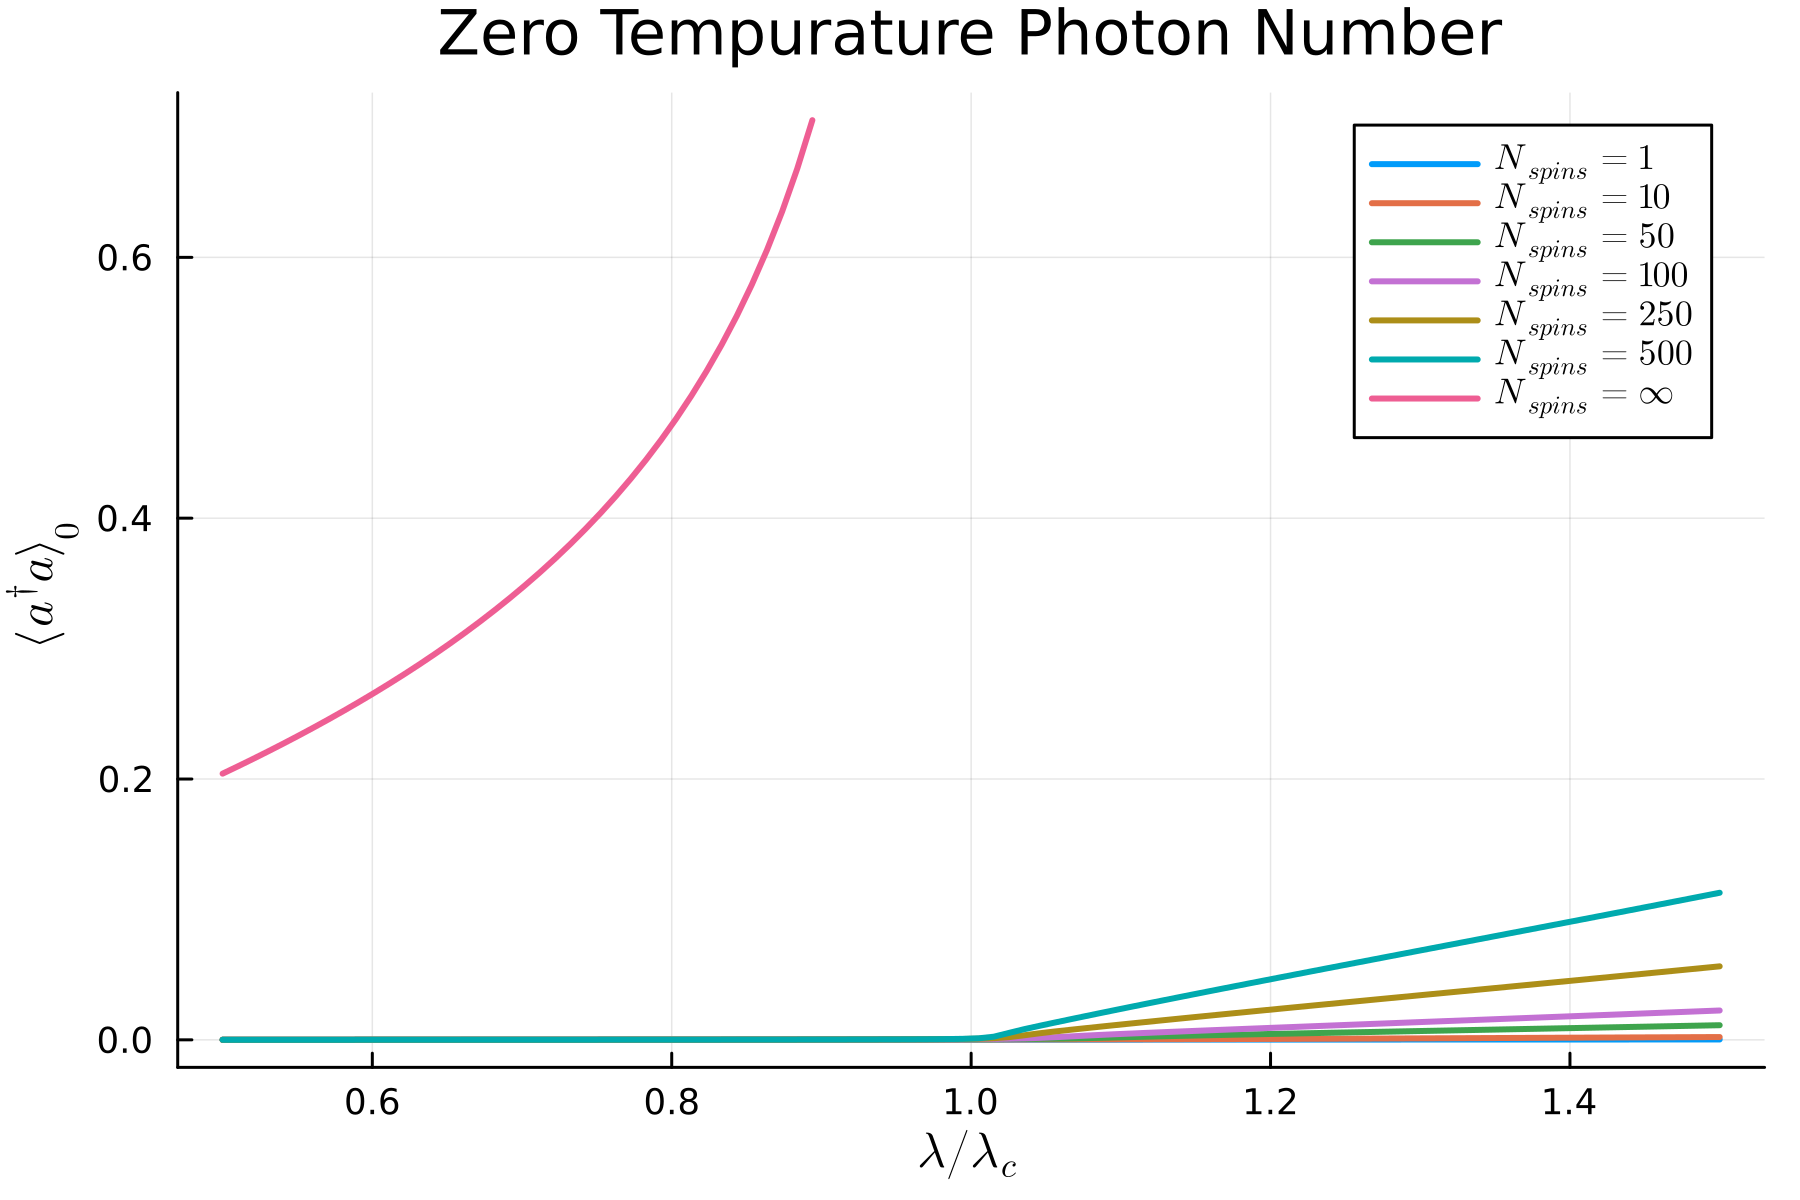

"c:\\Users\\henhen724\\Desktop\\LabNotebooks\\DickeModel\\analysis\\figures\\zero_temp_photon_number.png"

In [9]:
using Plots
Δc = 2π*20
ωz = 2π*0.01
λc = 1/2*sqrt(Δc * ωz) 
num_points = 100
λrels = LinRange(0.5, 1.5, num_points)
Nspins = [1,10,50,100,250,500]
λrelsBelow = λrels[1:40]

adagaInf = sqrt.((λrelsBelow*λc).^2 ./ (2*ωz*Δc*(1 .- λrelsBelow.^2)))
plot(λrels, PNK0150, label=reshape(["\$N_{spins}=$(Nspins[j])\$" for j in 1:length(Nspins)], 1, :), linewidth=2, dpi=300)
plot!(λrelsBelow, adagaInf, label="\$N_{spins}=\\infty\$", linewidth=2, dpi=300)
xlabel!(L"\lambda/\lambda_{c}")
ylabel!("\$\\langle a^\\dag a \\rangle_{0}\$") 
title!("Zero Tempurature Photon Number")
display(current())

savefig("figures/zero_temp_photon_number.png")

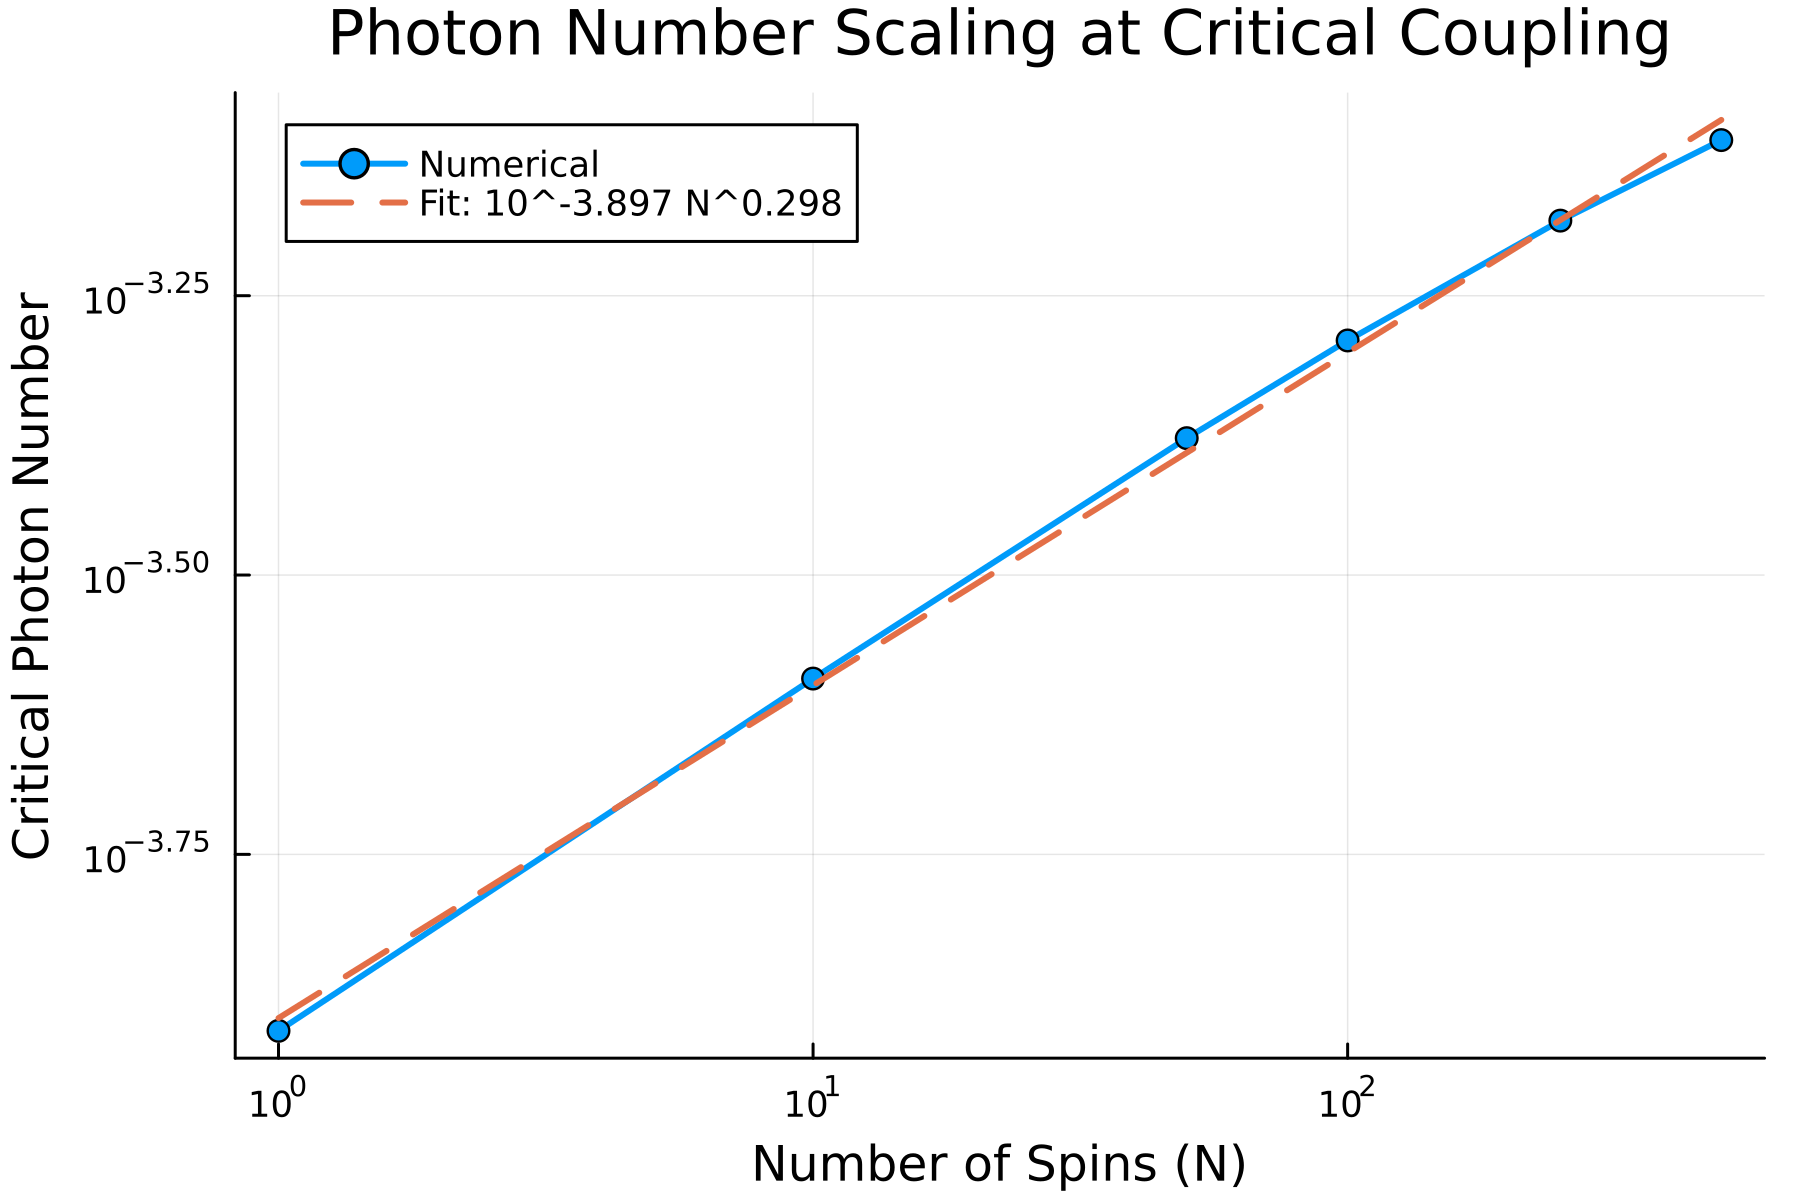

"c:\\Users\\henhen724\\Desktop\\LabNotebooks\\DickeModel\\analysis\\figures\\critical_photon_scaling.png"

In [65]:
# Find indices closest to λ/λc = 1 for each dataset
crit_idx = findmin(abs.(λrels .- 1))[2]

# Extract photon numbers at critical point for each N
crit_photons = PNK0150[crit_idx, :]

# Fit to linear function in log-log space
log_N = log10.(Nspins)
log_photons = log10.(crit_photons)
fit = Polynomials.fit(log_N, log_photons, 1)
slope = fit[1]
intercept = fit[0]

# Create log-log plot with fit line
using Plots
plot(Nspins, crit_photons, 
    xscale=:log10, 
    yscale=:log10,
    marker=:circle,
    linewidth=2,
    label="Numerical",
    dpi=300)

# Add fitted line
N_fit = 10 .^ range(log10(minimum(Nspins)), log10(maximum(Nspins)), length=100)
photons_fit = 10 .^ (slope .* log10.(N_fit) .+ intercept)
plot!(N_fit, photons_fit, 
    linewidth=2,
    xscale=:log10,
    yscale=:log10,
    label="Fit: 10^$(round(intercept, digits=3)) N^$(round(slope, digits=3))",
    linestyle=:dash)

xlabel!("Number of Spins (N)")
ylabel!("Critical Photon Number") 
title!("Photon Number Scaling at Critical Coupling")
display(current())

savefig("figures/critical_photon_scaling.png")


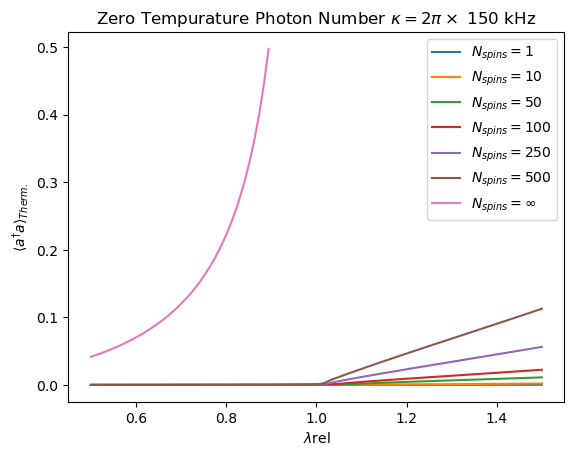

In [12]:
κ = 2π*0.15
Δc = 2π*20
ωz = 2π*0.01
λc = 1/2*sqrt((Δc^2+κ^2)/Δc * ωz) 

λrelsBelow = λrels[1:40]

adagaInf = (λrelsBelow*λc).^2 ./ (2*ωz*Δc*(1 .- λrelsBelow.^2))

for j in 1:length(Nspins)
    plot(λrels, PNK0150[:,j], label="\$N_{spins}=$(Nspins[j])\$")
end
plot(λrelsBelow, adagaInf, label="\$N_{spins}=\\infty\$")
PyPlot.xlabel("\$\\lambda\$rel")
PyPlot.ylabel("\$\\langle a^\\dag a \\rangle_{Therm.}\$")
PyPlot.title("Zero Tempurature Photon Number \$\\kappa=2\\pi\\times\$ 150 kHz")
PyPlot.legend()
PyPlot.display_figs()

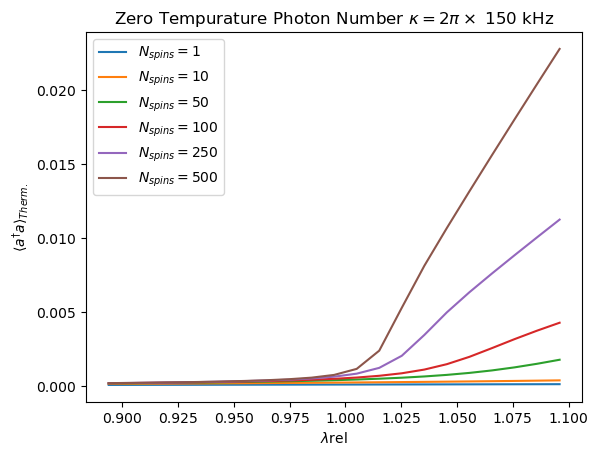

In [13]:
for j in 1:length(Nspins)
    plot(λrels[40:60], PNK0150[40:60,j], label="\$N_{spins}=$(Nspins[j])\$")
end
PyPlot.xlabel("\$\\lambda\$rel")
PyPlot.ylabel("\$\\langle a^\\dag a \\rangle_{Therm.}\$")
PyPlot.title("Zero Tempurature Photon Number \$\\kappa=2\\pi\\times\$ 150 kHz")
PyPlot.legend()
PyPlot.display_figs()

In [ ]:
κ = 2π*0.15
Δc = 2π*20
ωz = 2π*0.01
λc = 1/2*sqrt((Δc^2+κ^2)/Δc * ωz) 

λrelsBelow = λrels[1:40]

adagaInf = (λrelsBelow*λc).^2 ./ (2*ωz*Δc*(1 .- λrelsBelow.^2))

for j in 1:length(Nspins)
    plot(λrels, PN[:,j], label="\$N_{spins}=$(Nspins[j])\$")
end
plot(λrelsBelow, adagaInf, label="\$N_{spins}=\\infty\$")
PyPlot.xlabel("\$\\lambda\$rel")
PyPlot.ylabel("\$\\langle a^\\dag a \\rangle_{Therm.}\$")
PyPlot.title("Zero Tempurature Photon Number")
PyPlot.legend()
PyPlot.display_figs()

In [11]:
num_points = 100
λrels = LinRange(0.5, 1.5, num_points)
Nspins = [10,50,100,250]
PNSS = zeros(num_points, length(Nspins))

for i in 1:num_points
    for j in 1:length(Nspins)
        ρ_it, fb, sb, bases, a, Sx, Sy, Sz = dicke_model_SS_rho(λrels[i], Nspin=Nspins[j], κ=200.0)
        PNSS[i,j] = real(expect(dagger(a)*a, ρ_it))
        println("Finished running lambda=$(λrels[i]) Nspin=$(Nspins[j])")
    end
end

In [1]:
κ = 2π*0.15
Δc = 2π*20
ωz = 2π*0.01
λc = 1/2*sqrt((Δc^2+κ^2)/Δc * ωz) 

λrelsBelow = λrels[1:40]

adagaInf = (λrelsBelow*λc).^2 ./ (2*ωz*Δc*(1 .- λrelsBelow.^2))

for j in 1:length(Nspins)
    plot(λrels, PNSS[:,j], label="\$N_{spins}=$(Nspins[j])\$")
end
plot(λrelsBelow, adagaInf, label="\$N_{spins}=\\infty\$")
PyPlot.xlabel("\$\\lambda\$rel")
PyPlot.ylabel("\$\\langle a^\\dag a \\rangle_{S.S.}\$")
PyPlot.title("Steady State Photon Number")
PyPlot.legend()
PyPlot.display_figs()

UndefVarError: UndefVarError: `λrels` not defined